In [9]:
import torch
import matplotlib.pyplot as plt
from  PIL import Image
import os

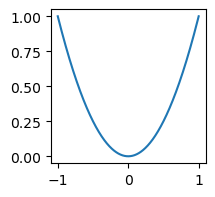

In [10]:
def fun(input_x):
    return input_x**2

# Helper function for saving GIFs
def save_gif_PIL(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)
    [os.remove(file) for file in files]

x=torch.linspace(-1,1,1000)
y=fun(x)
fig,ax=plt.subplots(1,1)
fig.set_size_inches(2,2)
plt.plot(x,y)

## Gradient Descent

In [11]:
x_start=torch.tensor(-0.5,requires_grad=True)
alpha=0.99
file_paths = []

# Gradient descent loop with visualization
for i in range(1,30):
    # Plot the current state
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(2, 2)
    ax.plot(x, y)
    ax.scatter(x_start.detach(), fun(x_start).detach(), color='red')
    file_name = f"frame_{i}.png"
    ax.set_title(f"Iter:{i}")
    fig.tight_layout(pad=0.1)
    plt.savefig(file_name)
    file_paths.append(file_name)
    plt.close(fig)

    # Compute the gradient
    fun(x_start).backward()
    with torch.no_grad():
        x_start -= alpha * x_start.grad
        x_start.grad.zero_()
    
# Save all frames as a GIF
save_gif_PIL("00-opt-GradientDescent.gif", file_paths, fps=3, loop=0)

## Exponentailly Weighted Avg

[Understanding Exponentially Weighted Averages (C2W2L04) Andrew NG](https://youtu.be/NxTFlzBjS-4?si=PYam0k9Uju6Ojy1V)

$$
v_t=\beta v_{t-1}+(1-\beta)\theta_t
$$

For our case $v_t$ is $\theta^{\text{avg}}_t$
$$
\theta^{\text{avg}}_t=\beta \theta^{\text{avg}}_{t-1}+(1-\beta)\theta_t
$$


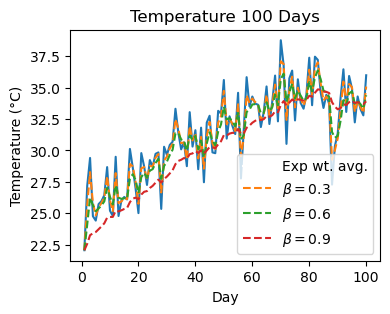

In [12]:
# Parameters
n_days = 100
avg_temp = 25  # average temperature in degrees Celsius
temp_var = 10  # maximum variation from the average temperature

beta=0.9
# Generate temperature data
x = torch.linspace(0, 0.5 * torch.pi, n_days)
sin_wave = temp_var * torch.sin(x)
noise = torch.normal(mean=0, std=2, size=(n_days,))
temps = avg_temp + sin_wave + noise
days = torch.arange(1, n_days + 1)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 3)
ax.plot(days, temps)
ax.plot([],[],"w",label="Exp wt. avg.")
temps_expAvg = torch.zeros(n_days)
temps_expAvg[0] = temps[0]
for beta in [0.3,0.6,0.9]:
    for i in range(1,n_days):
        temps_expAvg[i] = beta*temps_expAvg[i-1]+(1-beta)*temps[i]
    ax.plot(days, temps_expAvg,"--",label="$\\beta=$"+f"{beta}")
ax.legend()
# Plot the temperature data
ax.set_xlabel('Day')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Temperature 100 Days')
plt.show()

## GD with Momentum

$$
\begin{align*}
V_{dw} &= \beta V_{dw}+(1-\beta)dw \\
w &= w-\alpha V_{dw}
\end{align*}
$$

$\beta=0.9$ is most widely used value.

In [13]:
x=torch.linspace(-1,1,100)
y=fun(x)
w=torch.tensor(-0.5,requires_grad=True)
vdw=torch.tensor(0.)
alpha,beta=0.99,0.9
file_paths = []

# Gradient descent loop with visualization
for i in range(1,30):
    # Plot the current state
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(2, 2)
    ax.plot(x, y)
    ax.scatter(w.detach(), fun(w).detach(), color='red')
    file_name = f"frame_{i}.png"
    ax.set_title(f"Iter:{i}")
    fig.tight_layout(pad=0.1)
    plt.savefig(file_name)
    file_paths.append(file_name)
    plt.close(fig)

    # Update Params
    fun(w).backward()
    with torch.no_grad():
        vdw = beta*vdw+(1-beta)*w.grad
        w -= alpha * vdw
        w.grad.zero_()
    
# Save all frames as a GIF
save_gif_PIL("00-opt-GradientDescentWithMomentum.gif", file_paths, fps=3, loop=0)

## RMSprop

$$
\begin{align*}
S_{dw} &= \beta_2 S_{dw}+(1-\beta_2)dw^2 \\
w &= w-\alpha \frac{dw}{\sqrt{S_{dw}}}
\end{align*}
$$


In [14]:
x=torch.linspace(-1,1,100)
y=fun(x)
w=torch.tensor(-0.5,requires_grad=True)
sdw=torch.tensor(0.)
alpha,beta2=0.9,0.9
file_paths = []

# Gradient descent loop with visualization
for i in range(1,30):
    # Plot the current state
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(2, 2)
    ax.plot(x, y)
    ax.scatter(w.detach(), fun(w).detach(), color='red')
    file_name = f"frame_{i}.png"
    ax.set_title(f"Iter:{i}")
    fig.tight_layout(pad=0.1)
    plt.savefig(file_name)
    file_paths.append(file_name)
    plt.close(fig)

    # Update Params
    fun(w).backward()
    with torch.no_grad():
        sdw = beta2*sdw+(1-beta2)*w.grad**2
        w -= alpha * w.grad/torch.sqrt(sdw)
        w.grad.zero_()
    
# Save all frames as a GIF
save_gif_PIL("00-opt-RMSProp.gif", file_paths, fps=3, loop=0)

## Adam optimization

Adaptive moment estimation.

$$
\begin{align*}
V_{dw} &= \beta_1 V_{dw}+(1-\beta_1)dw \\
S_{dw} &= \beta_2 S_{dw}+(1-\beta_2)dw^2 \\

V^{\text{corrected}}_{dw} &= \frac{V_{dw}}{1-\beta^t_1}\   \text{Bias correction}\\
S^{\text{corrected}}_{dw} &= \frac{S_{dw}}{1-\beta^t_2}\   \text{Bias correction}\\

w &= w - \alpha \frac{V^{\text{corrected}}_{dw}}{\sqrt{S^{\text{corrected}}_{dw}}+\epsilon}
\end{align*}
$$

Common values of $\beta_1 = 0.9, \beta_2=0.999$ and $\epsilon=10^{-8}$.

<p align="center">
  <img src="_ref/adam.png" alt="Image" style="width:50%;">
</p>



In [18]:
x=torch.linspace(-1,1,100)
y=fun(x)
w=torch.tensor(-0.5,requires_grad=True)
sdw=torch.tensor(0.)
vdw=torch.tensor(0.)
alpha,beta1,beta2,eps=0.9,0.9,0.999,1e-8
file_paths = []

# Gradient descent loop with visualization
for i in range(1,30):
    # Plot the current state
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(2, 2)
    ax.plot(x, y)
    ax.scatter(w.detach(), fun(w).detach(), color='red')
    file_name = f"frame_{i}.png"
    ax.set_title(f"Iter:{i}")
    fig.tight_layout(pad=0.1)
    plt.savefig(file_name)
    file_paths.append(file_name)
    plt.close(fig)

    # Update Params
    fun(w).backward()
    with torch.no_grad():
        vdw = beta1*vdw+(1-beta1)*w.grad
        sdw = beta2*sdw+(1-beta2)*w.grad**2
        vdw_corr = vdw/(1-beta1**i)
        sdw_corr = sdw/(1-beta2**i)
        w -= alpha * vdw_corr/(torch.sqrt(sdw_corr)+eps)
        w.grad.zero_()
    
# Save all frames as a GIF
save_gif_PIL("00-opt-ADAM.gif", file_paths, fps=3, loop=0)